# Identifying Outliers in Proportions using Funnel Charts

[Andrew Wheeler](https://crimede-coder.com/)

This shows how to create a funnel chart to identify outliers in proportions in python. It calculates the overall proportion of the outcome in the sample.

Other examples:
 - [identifying outliers in homicide rates for cities with varying sizes](https://andrewpwheeler.com/2014/10/12/using-funnel-charts-for-monitoring-rates/)
 - [Monitoring Use of Force in New Jersey](https://andrewpwheeler.com/2018/12/02/monitoring-use-of-force-in-new-jersey/)

This is also one way you can build an [Early Intervention System](https://crimede-coder.com/blogposts/2024/EIS) that does not rely on a simple three events and you are flagged as bad.

In [1]:
import cdcplot as cdc # my plot functions, template
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta

np.random.seed(10)

# simulate data, good/normal/bad
sim = {'normal': [95, 0.5],
       'bad': [6, 0.3],
       'good': [3, 0.7],}

# how many observations
low, hig = 10, 200

data = []
for k,v in sim.items():
    n = np.random.randint(low,hig,v[0])
    d = np.random.binomial(n,v[1])
    df = pd.DataFrame(zip(n,d),columns=['Den','Num'])
    df['group'] = k
    data.append(df)

data = pd.concat(data)
data['prop'] = data['Num']/data['Den']
overprop = data['Num'].sum()/data['Den'].sum() # overall proportion

print(f'Overall proportion in the sample is {overprop:.2f}')
data.sort_values(by='prop',inplace=True)
data # sorting gets a few outliers

Overall proportion in the sample is 0.49


,Den,Num,group,prop
11,10,2,normal,0.200000
54,25,7,normal,0.280000
4,92,26,bad,0.282609
5,194,57,bad,0.293814
2,192,59,bad,0.307292
...,...,...,...,...
63,38,24,normal,0.631579
85,22,15,normal,0.681818
2,175,123,good,0.702857
1,24,17,good,0.708333


In [2]:
# low and upper bounds binomial confidence interval, Clopper-Pearson exact
def binom_int(num,den, confint=0.95):
    quant = (1 - confint)/2.
    low = beta.ppf(quant, num, den - num + 1)
    high = beta.ppf(1 - quant, num + 1, den - num)
    return (np.nan_to_num(low), np.where(np.isnan(high), 1, high))

# This estimates where the funnel should be based on the overall proportion
# in your data
lo, ho = binom_int(data['Den']*overprop,data['Den'])
data['lowt'] = lo
data['higt'] = ho

lv = data['prop'] < data['lowt']
hv = data['prop'] > data['higt']
data['flag'] = lv*-1 + hv*1

# A few false positives and one false negative
data[(data['flag'] != 0) | (data['group'] != 'normal')]

,Den,Num,group,prop,lowt,higt,flag
54,25,7,normal,0.280000,0.288703,0.697920,-1
4,92,26,bad,0.282609,0.386535,0.598720,-1
5,194,57,bad,0.293814,0.420041,0.564946,-1
2,192,59,bad,0.307292,0.419658,0.565332,-1
3,109,34,bad,0.311927,0.395301,0.589875,-1
0,35,11,bad,0.314286,0.319860,0.666230,-1
45,103,37,normal,0.359223,0.392457,0.592744,-1
92,107,41,normal,0.383178,0.394380,0.590804,-1
1,25,11,bad,0.440000,0.288703,0.697920,0
31,136,80,normal,0.588235,0.405666,0.579424,1


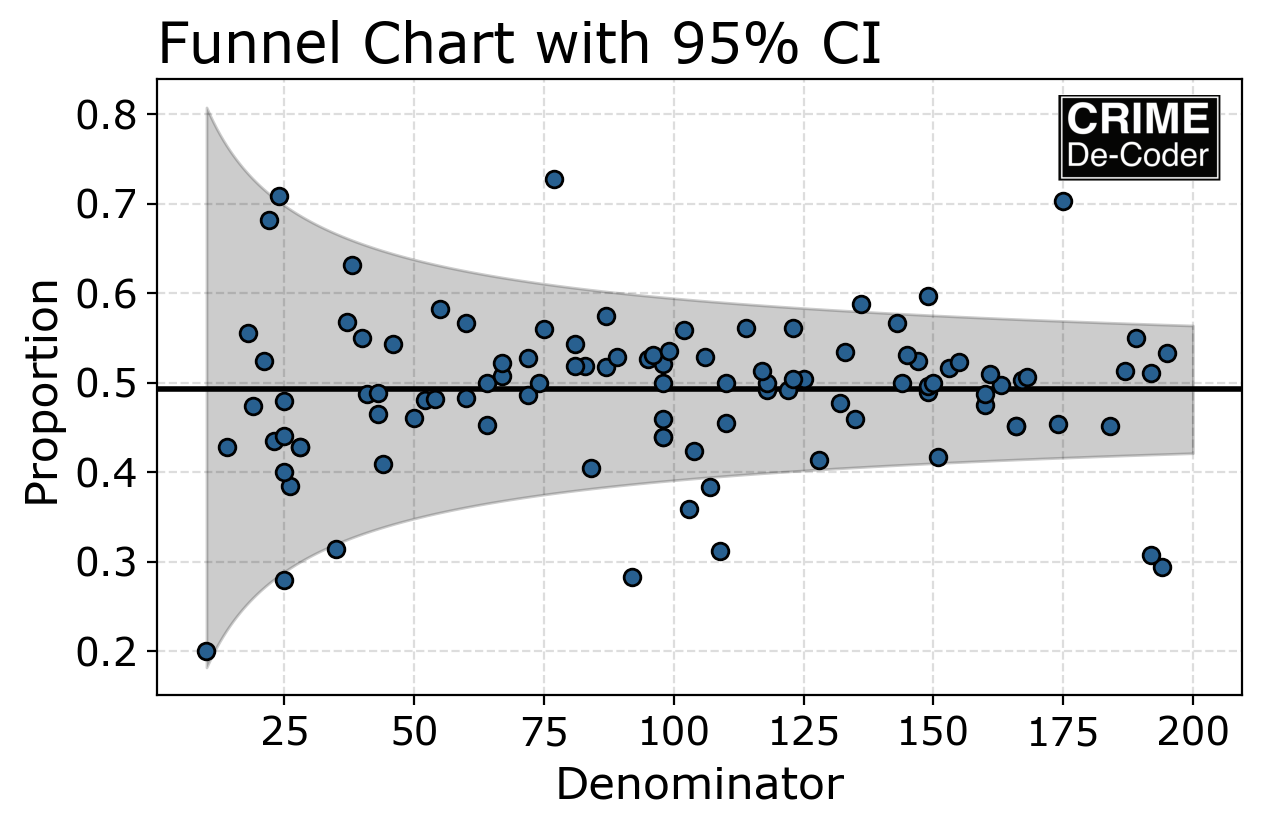

In [3]:
x = np.linspace(low,hig,300)
lw,hi = binom_int(x*overprop,x)

fig, ax = plt.subplots(figsize=(7,4))
ax.fill_between(x,lw,hi,alpha=0.2, color='k')
ax.axhline(overprop,color='k',linewidth=2)
ax.plot(data['Den'],data['prop'],'o',markeredgecolor='k')
ax.set_xlabel("Denominator")
ax.set_ylabel("Proportion")
ax.set_title('Funnel Chart with 95% CI')
cdc.add_logo(ax, loc=[0.83,0.83], size=0.15)
plt.savefig('FunnelProportion.png',dpi=500, bbox_inches='tight')
plt.show()